In [1823]:
import math
import point_similarity as ps
import scipy.integrate as integrate
import pylab
import mpmath
from scipy.misc import derivative
import plotly
from plotly import graph_objs as go
import sys
import read_arbor_reconstruction as rar
import networkx as nx

In [1454]:
def calc_coeff(G, x, y, p, q):
    b = ((q - y - G*(p*p - x*x))/(p-x))
    c = (q - G*p*p - b*p)

    # assert (G * x * x) + (b * x) + c == y
    # assert (G * p * p) + (b * p) + c == q
    
    return b, c

In [1455]:
calc_coeff(0, 4, 7.5, 7, 2)

(-1.8333333333333333, 14.833333333333332)

In [1524]:
def curve_length(G, x0, y0, p, q):        
    b, c = calc_coeff(G, x0, y0, p, q)
    def differential(x):
        return pylab.sqrt(1 + (2*G*x + b)**2)
    curve, tolerance = integrate.quad(differential, min(x0, p), max(x0, p))
    return curve

In [1525]:
curve_length(0, 3.8, 7.4, 7, 2)

6.276941930590086

In [1526]:
def distance_from_base(root_distance, x, y, x1, y1):
    pair1 = [x, y]
    pair2 = [x1, y1]
    distance = math.dist(pair1, pair2)
    if(x,y) == (x1, y1):
        assert distance == 0
    return distance + root_distance

In [1527]:
distance_from_base(100, 3, 7, 3.8, 7.4)

100.89442719099992

In [1573]:
def total_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q):
    curve = curve_length(G, x1, y1, p, q)
    to_root = distance_from_base(root_distance, x0, y0, x1, y1)
    wiring = curve
    delay = (curve + to_root)
    cost = (alpha * wiring) +  ((1 - alpha) * delay)
    #print("curve = ", curve, "to root = " , to_root, "wiring = ", wiring, "delay = ", delay, "total cost = ", cost)
   # cost = curve + (1 - alpha) * distance_from_base(root_distance, x0, y0, x1, y1)
    return cost

In [1569]:
#for i in pylab.arange(3, 8, 0.01):
   # total_cost(0.8, 0, 0, 3, 7, i, 7, 7, 2)

In [1553]:
def length_func(x0, y0, x1, y1):
    length = pylab.sqrt((x1 - x0)**2 + (y1 - y0)**2)
    return length

In [1984]:
def get_theta(x0, y0, x1, y1):
    theta = pylab.arctan((abs(y1 - y0))/(abs(x1 - x0)))
    return theta

In [1891]:
def find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q):
    results = []
    min_t = 0
    delta = 0.01
    max_t = 1
    best_t = math.inf
    best_cost = math.inf
    l = length_func(x0, y0, x1, y1)
    theta = get_theta(x0, y0, x1, y1)
    x_opt = None
    y_opt = None
    best_x = None
    best_y = None
    for t in pylab.arange(min_t, max_t + delta, delta):
        new_x = x0 + t*l*cos(theta)
        new_y = y0 + t*l*sin(theta)
        x_curr = pylab.linspace(min(p, new_x), max(p, new_x))
        cost = total_cost(alpha, G, root_distance, x0, y0, new_x, new_y, p, q)
        if cost < best_cost:
            best_cost = cost
            best_t = t
            b, c = calc_coeff(G, new_x, new_y, p, q)
            best_x = new_x
            best_y = new_y
            #x_opt = x_curr
            #y_opt = G * x_opt ** 2 + b * x_opt + c
        '''
        if t % 0.2 == 0:
            b, c = calc_coeff(G, new_x, new_y, p, q)
            y_inter =  G * x_curr ** 2 + b * x_curr + c
            intermediate_line = go.Scatter(x = x_curr,y = y_inter, mode = "lines", name = str(cost))
            fig.add_trace(intermediate_line)
           ''' 
        results.append(cost)
    ##opt_line = go.Scatter(x = x_opt, y = y_opt, mode = "lines", name = "Optimal: " + str(best_cost))
    ##fig.add_trace(opt_line)
    return best_cost, best_t, best_x, best_y, p, q

In [1801]:
'''
pt1 = [5, 0.1]
pt2 = [-13, 2]

p_pt = 7
q_pt = 2
G = 0
alpha = 0.5
Droot = 0
main = go.Scatter(x=pt1, y=pt2, name="main root segment")
pq = go.Scatter(x = [p_pt], y= [q_pt], name="(p,q)")

example_fig = go.Figure()
example_fig.add_trace(main)
example_fig.add_trace(pq)

find_best_cost(alpha, G, Droot, pt1[0], pt2[0], pt1[1], pt2[1], p_pt, q_pt)
example_fig.update_layout(xaxis_range=[2.5, 6.5])
example_fig.update_layout(yaxis_range=[5.5, 8.5])
example_fig.show()
'''

'\npt1 = [5, 0.1]\npt2 = [-13, 2]\n\np_pt = 7\nq_pt = 2\nG = 0\nalpha = 0.5\nDroot = 0\nmain = go.Scatter(x=pt1, y=pt2, name="main root segment")\npq = go.Scatter(x = [p_pt], y= [q_pt], name="(p,q)")\n\nexample_fig = go.Figure()\nexample_fig.add_trace(main)\nexample_fig.add_trace(pq)\n\nfind_best_cost(alpha, G, Droot, pt1[0], pt2[0], pt1[1], pt2[1], p_pt, q_pt)\nexample_fig.update_layout(xaxis_range=[2.5, 6.5])\nexample_fig.update_layout(yaxis_range=[5.5, 8.5])\nexample_fig.show()\n'

In [1563]:
def get_length_and_theta(x0, y0, x1, y1):
    length = length_func(x0, y0, x1, y1)
    theta = get_theta(x0, y0, x1, y1)
    return length, theta

In [1811]:
def three_line_segments(alpha, G, root_distance, x0, y0, x1, y1, x2, y2, x3, y3, p, q):
    min_t = 0
    delta = 0.01
    max_t = 1
    
    s1 = find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q)
    
    segment1_length = length_func(x0, y0, x1, y1)
    s2 = find_best_cost(alpha, G, root_distance + segment1_length, x1, y1, x2, y2, p, q)

    segment2_length = length_func(x1, y1, x2, y2)
    s3 = find_best_cost(alpha, G, root_distance + segment1_length + segment2_length, x2, y2, x3, y3, p, q)
    print(s1)
    print(s2)
    print(s3)
    
    
    return min(s1[0], s2[0], s3[0])

In [1812]:
three_line_segments(1, 0, 10, 0, 0, 0.1, 6, 0.3, 13, 0.2, 19, 2, 10)

(4.428317965096906, 1.0, 0.09999999999999934, 6.0)
(1.7850086834522678, 0.58, 0.21600000000000036, 10.06)
(3.448187929913334, 0.0, 0.3, 13.0)


1.7850086834522678

In [1766]:
def get_xy_coords(t, x0, y0, x1, y1):
    x = x0 + t * get_length_and_theta(x0, y0, x1, y1)[0] * cos(get_length_and_theta(x0, y0, x1, y1)[1])
    y = y0 + t * get_length_and_theta(x0, y0, x1, y1)[0] * sin(get_length_and_theta(x0, y0, x1, y1)[1])
    return x, y

In [1767]:
get_xy_coords(1, 0.1, 6, 0.3, 13)

(0.30000000000000066, 13.0)

In [1805]:
s2_t = find_best_cost(1, 0, 10, 0.1, 6, 0.3, 13, 2, 10)[3]
s2_t

10.06

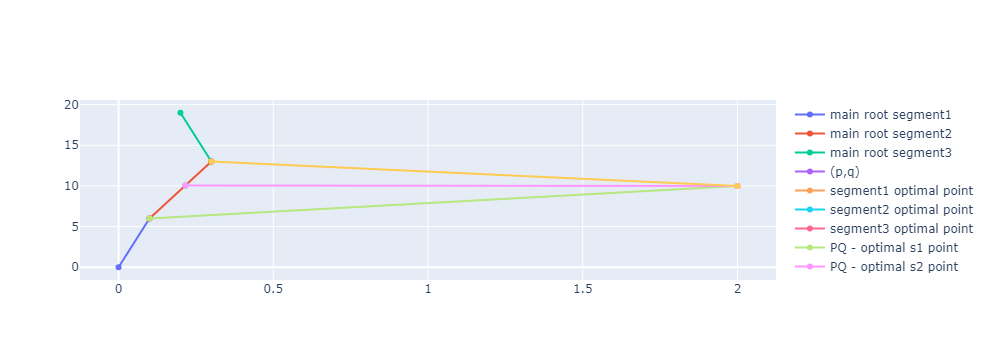

In [1817]:
pt1 = [0, 0.1]
pt2 = [0, 6]

pt3 = [0.1, 0.3]
pt4 = [6, 13]

pt5 = [0.3, 0.2]
pt6 = [13, 19]
p_pt = 2
q_pt = 10
G = 0
alpha = 1
Droot = 10

s1_t = find_best_cost(alpha, G, Droot, pt1[0], pt2[0], pt1[1], pt2[1], p_pt, q_pt)[1]
s1_opt = get_xy_coords(s1_t, pt1[0], pt2[0], pt1[1], pt2[1])

s2_t = find_best_cost(alpha, G, Droot, pt1[1], pt2[1], pt3[1], pt4[1], p_pt, q_pt)[1]
s2_opt = get_xy_coords(s2_t, pt1[1], pt2[1], pt3[1], pt4[1])

s3_t = find_best_cost(alpha, G, Droot, pt3[1], pt4[1], pt5[1], pt6[1], p_pt, q_pt)[1]
s3_opt = get_xy_coords(s3_t, pt3[1], pt4[1], pt5[1], pt6[1])

segment1 = go.Scatter(x=pt1, y=pt2, name="main root segment1")
segment2 = go.Scatter(x=pt3, y=pt4, name="main root segment2")
segment3 = go.Scatter(x=pt5, y=pt6, name="main root segment3")

pq = go.Scatter(x = [p_pt], y= [q_pt], name="(p,q)")

s1_pt = go.Scatter(x = [s1_opt[0]], y = [s1_opt[1]], name = "segment1 optimal point")
s2_pt = go.Scatter(x = [s2_opt[0]], y = [s2_opt[1]], name = "segment2 optimal point")
s3_pt = go.Scatter(x = [s3_opt[0]], y = [s3_opt[1]], name = "segment3 optimal point")

s1_pq_x = [s1_opt[0], p_pt]
s1_pq_y = [s1_opt[1], q_pt]

s1_pq = go.Scatter(x=s1_pq_x, y=s1_pq_y, name="PQ - optimal s1 point")

s2_pq_x = [s2_opt[0], p_pt]
s2_pq_y = [s2_opt[1], q_pt]

s2_pq = go.Scatter(x=s2_pq_x, y=s2_pq_y, name="PQ - optimal s2 point")


s3_pq_x = [s3_opt[0], p_pt]
s3_pq_y = [s3_opt[1], q_pt]

s3_pq = go.Scatter(x=s3_pq_x, y=s3_pq_y, name="PQ - optimal s3 point")

example_fig = go.Figure()
example_fig.add_trace(segment1)
example_fig.add_trace(segment2)
example_fig.add_trace(segment3)
example_fig.add_trace(pq)
example_fig.add_trace(s1_pt)
example_fig.add_trace(s2_pt)
example_fig.add_trace(s3_pt)
example_fig.add_trace(s1_pq)
example_fig.add_trace(s2_pq)
example_fig.add_trace(s3_pq)
# find_best_cost(alpha, G, Droot, pt1[0], pt2[0], pt1[1], pt2[1], p_pt, q_pt, example_fig)
#three_line_segments(alpha, G, Droot, pt1[0], pt2[0], pt1[1], pt2[1], pt3[1], pt4[1], pt5[1], pt6[1], p_pt, q_pt)
example_fig.show()

In [1992]:
def arbor_best_cost(fname, alpha, G, root_distance):
    arbor = rar.read_arbor_full(fname)
    main_root = []
    lat_tips = []
    line_segments = {}
    point_drawing = go.Figure()
    for node in arbor.nodes():
        if arbor.nodes[node]["label"] == ("main root") or arbor.nodes[node]["label"] == ("main root base"):
            main_root.append(node)
        if arbor.nodes[node]["label"] == ("lateral root tip"):
            lat_tips.append(node)
    for i in range(1, len(main_root)):
        line_segments[i] = main_root[i - 1], main_root[i]


    # loop through lateral root tips and go through each line segment, return best cost and point
    final = []
    curr_dist = 0
    firstTime = True
    for tip in lat_tips:
        results = []
        p = tip[0]
        q = tip[1]
        for seg in line_segments:
            x0 = line_segments[seg][0][0]
            y0 = line_segments[seg][0][1] 
            x1 = line_segments[seg][1][0]
            y1 = line_segments[seg][1][1]
            if firstTime == True:
                result = find_best_cost(alpha, G, root_distance, x0, y0, x1, y1, p, q)
                firstTime == False
            else: 
                distance = length_func(x0, y0, x1, y1)
                curr_dist += distance
                result = find_best_cost(alpha, G, root_distance + curr_dist, x0, y0, x1, y1, p, q)
            results.append(result)
        final.append(min(results))
    pq_drawings = get_tip_drawings(lat_tips)
    for p_and_q in pq_drawings:
        point_drawing.add_trace(p_and_q)
    
    segment_drawings = get_line_segment_drawings(line_segments)
    for line in segment_drawings:
        point_drawing.add_trace(line)

    opt_lines = get_opt_to_pq_drawings(final)
    for opt in opt_lines:
        point_drawing.add_trace(opt)
    point_drawing.show()
    return final

In [1993]:
def get_line_segment_drawings(line_segments):
    segment_drawings = []
    for seg in line_segments:
        x0 = line_segments[seg][0][0]
        y0 = line_segments[seg][0][1] 
        x1 = line_segments[seg][1][0]
        y1 = line_segments[seg][1][1]

        xpoints = [x0, x1]
        ypoints = [y0, y1]

        segment = go.Scatter(x= xpoints, y=ypoints, name="segment")
        segment_drawings.append(segment)
    return segment_drawings

In [1994]:
def get_tip_drawings(lat_tips):
    pq_drawings = []
    for tip in lat_tips:
        p = tip[0]
        q = tip[1]
        pq = go.Scatter(x = [p], y= [q], name= str(tip))
        pq_drawings.append(pq)
    return pq_drawings

In [1995]:
dist1 = length_func(6.316246, 4.788182, 6.248517, 5.230901)
find_best_cost(0.5, 0, dist1, 6.248517, 5.230901, 6.172466, 5.448168, 8.934018, 7.703327)
le, the = get_length_and_theta(6.248517, 5.230901, 6.172466, 5.448168)
le, the
supposed_x = 6.248517 + (1 * le * cos(the))
supposed_y = 5.230901 + 1 * (le * sin(the))
supposed_x, supposed_y, the
get_theta(6.248517, 5.230901, 6.172466, 5.448168)
supposed_x, supposed_y
total_cost(0.5, 0, dist1, 6.248517, 5.230901, 6.172466, 5.448168, 8.934018, 7.703327)
find_best_cost(0.5, 0, dist1, 6.248517, 5.230901, 6.172466, 5.448168, 8.934018, 7.703327)

(3.7879399901575335, 1.0, 6.324567999999999, 5.448168, 8.934018, 7.703327)

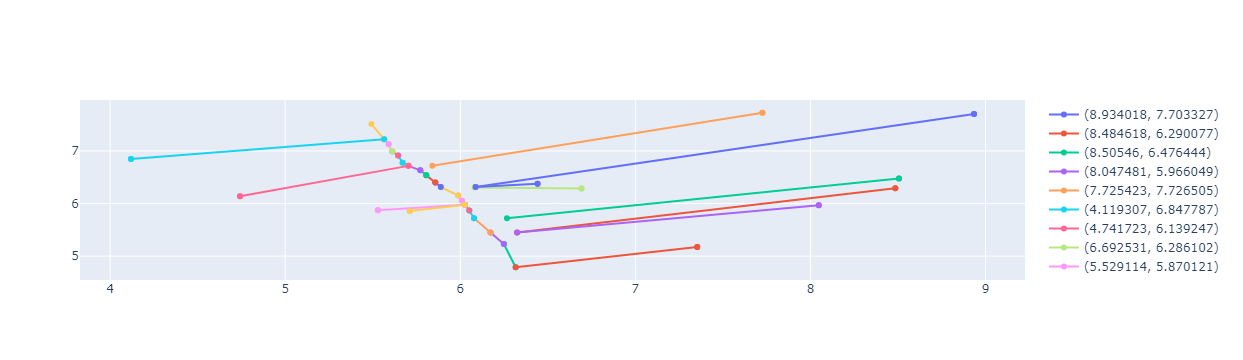

[(3.262298244096904, 1.0, 6.087401, 6.313534, 8.934018, 7.703327),
 (2.4334205058173595, 1.0, 6.324567999999999, 5.448168, 8.484618, 6.290077),
 (2.506920536979187, 1.0, 6.266559, 5.719055, 8.50546, 6.476444),
 (1.9141600043693008, 1.0, 6.324567999999999, 5.448168, 8.047481, 5.966049),
 (2.1933097172476685, 1.0, 5.840202, 6.716372, 7.725423, 7.726505),
 (1.4941227821210006, 0.0, 5.565074, 7.224829, 4.119307, 6.847787),
 (1.121669346844247, 0.0, 5.703528, 6.716372, 4.741723, 6.139247),
 (0.7002057292462316,
  0.9400000000000001,
  6.08144246,
  6.3038813199999995,
  6.692531,
  6.286102),
 (0.509058786738821, 0.0, 6.02648, 5.978601, 5.529114, 5.870121),
 (0.33765529113727855, 0.0, 6.02648, 5.978601, 5.711468, 5.857034),
 (0.4542613615077542, 1.0, 6.087401, 6.313534, 6.441282, 6.378145),
 (1.1061954037677977, 0.0, 6.316246, 4.788182, 7.3533, 5.173133)]

In [2004]:
arbor_best_cost('002_1_c_day4.csv', 0.5, 0, 0)

In [1966]:
def get_opt_to_pq_drawings(final):
    drawings = []
    for result in final:
        x0 = result[2]
        y0 = result[3]
        p = result[4]
        q = result[5]
        xcoords = [x0, p]
        ycoords = [y0, q]
        
        line = go.Scatter(x=xcoords, y=ycoords, name = str(result[0]))
        drawings.append(line)
    return drawings
    

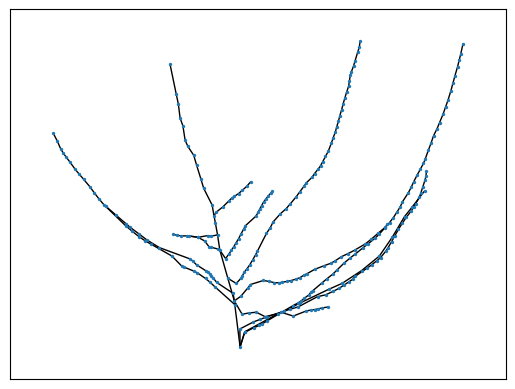

In [1833]:
G = rar.read_arbor_full('002_1_c_day4.csv')
coords = {}
for coordinate in list(G.nodes):
    coords[coordinate] = coordinate

nx.draw_networkx(G, pos = coords, with_labels = False, node_size = 2)

In [1834]:
list(G.nodes(data = True))

[((6.316246, 4.788182), {'label': 'main root base'}),
 ((6.248517, 5.230901), {'label': 'main root'}),
 ((6.172466, 5.448168), {'label': 'main root'}),
 ((6.078373, 5.719055), {'label': 'main root'}),
 ((6.051647, 5.865528), {'label': 'main root'}),
 ((6.02648, 5.978601), {'label': 'main root'}),
 ((6.009377, 6.051857), {'label': 'main root'}),
 ((5.988092, 6.152656), {'label': 'main root'}),
 ((5.888783, 6.313534), {'label': 'main root'}),
 ((5.857484, 6.399435), {'label': 'main root'}),
 ((5.805855, 6.535716), {'label': 'main root'}),
 ((5.771865, 6.631406), {'label': 'main root'}),
 ((5.703528, 6.716372), {'label': 'main root'}),
 ((5.67063, 6.775653), {'label': 'main root'}),
 ((5.644983, 6.913284), {'label': 'main root'}),
 ((5.611528, 6.990774), {'label': 'main root'}),
 ((5.590928, 7.125623), {'label': 'main root'}),
 ((5.565074, 7.224829), {'label': 'main root'}),
 ((5.492228, 7.511988), {'label': 'main root'}),
 ((6.370103, 4.928189), {'label': 'lateral root'}),
 ((6.481349, 4